In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

from keras.optimizers import SGD, Adam, Adadelta
from keras.layers import Dense, Flatten, Input, Activation
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot
from keras import Sequential
from keras.callbacks import EarlyStopping
from keras.layers.normalization import BatchNormalization
from sklearn.preprocessing import OneHotEncoder
from keras.layers import Dropout
import keras
from keras import regularizers

import h5py  # compress and save features

E:\Anaconda\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Loading data

In [2]:
%%time
with h5py.File('features_train.h5', 'r') as f:
    features = np.array(f['features'])

Wall time: 4min 54s


In [11]:
features.shape

NameError: name 'features' is not defined

In [2]:
%%time
with h5py.File('features_all_train.h5', 'r') as f:
    feature_combine = np.array(f['feature_all'])

Wall time: 6min 48s


In [12]:
feature_combine.shape

(244768, 11817)

In [6]:
%%time
with h5py.File('features_salary.h5', 'r') as f:
    salary = np.array(f['salary'])

Wall time: 25.2 ms


In [5]:
salary.shape

(244768,)

In [7]:
salary_log = np.log(salary)

In [8]:
%%time
with h5py.File('features_test.h5', 'r') as f:
    feature_test = np.array(f['features_test'])

Wall time: 2min 25s


In [15]:
feature_test.shape

(122463, 9736)

**observe salary**

In [9]:
true_salay_dataset = pd.read_csv('./dataset/random_forest_benchmark_test_rev1.csv')

In [10]:
ture_salay = true_salay_dataset['SalaryNormalized']

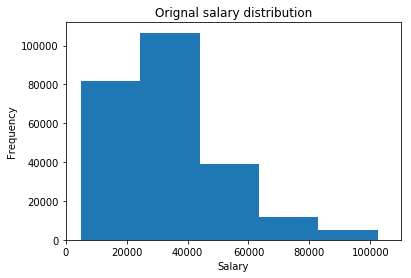

In [16]:
f1 = plt.figure(1)
plt.hist(salary)
plt.title('Orignal salary distribution')  
plt.ylabel("Frequency")  
plt.xlabel("Salary")
# plt with same scale
#plt.ylim(0,0.25)
plt.xlim(0,110000)
plt.savefig("Orignal salary distribution.PNG", dpi = 600)
plt.show()

**It could find the distribution of salay is not Gauusian, therefore, take log to this data**

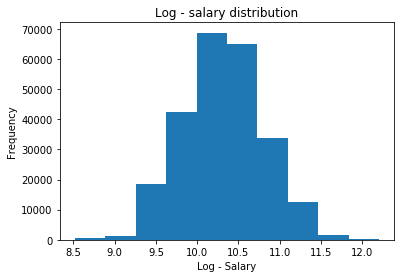

In [18]:
# make a histogram of the data array
salary_log = np.log(salary)
 
f1 = plt.figure(2)
plt.hist(salary_log)
plt.title('Log - salary distribution')  
plt.ylabel("Frequency")  
plt.xlabel("Log - Salary")
# plt with same scale
#plt.ylim(0,0.25)
#plt.xlim(0,110000)
plt.savefig("Log - salary distribution.PNG", dpi = 600)
plt.show()

# PCA analysis

In [ ]:
def zeroMean(dataMat):        
    meanVal=np.mean(dataMat,axis=0)     #get mean by columns
    newData=dataMat-meanVal  
    return newData,meanVal


def percentage2n(eigVals,percentage):  
    sortArray=np.sort(eigVals)          #ascend order 
    sortArray=sortArray[-1::-1]           
    arraySum=sum(sortArray)  
    tmpSum=0  
    num=0  
    for i in sortArray:  
        tmpSum+=i  
        num+=1  
        if tmpSum>=arraySum*percentage:  
            return num  


def pca(dataMat,percentage=0.99):  
    newData,meanVal=zeroMean(dataMat)  
    covMat=np.cov(newData,rowvar=0)      #covariance  
    eigVals,eigVects=np.linalg.eig(np.mat(covMat))      
    n=percentage2n(eigVals,percentage)                 #need n dimensionol data to get the convariance percentage
    eigValIndice=np.argsort(eigVals)            #ascend order 
    n_eigValIndice=eigValIndice[-1:-(n+1):-1]   
    n_eigVect=eigVects[:,n_eigValIndice]        
    lowDDataMat=newData*n_eigVect               #lower dimensional data  
    #reconMat=(lowDDataMat*n_eigVect.T)+meanVal  #reconstruct data  
    return lowDDataMat,n

**dimention too big to use this pca function**

# create train and test datasets

In [13]:
x_train = feature_combine[0:122384]
x_train.shape

(122384, 11817)

In [14]:
x_test = feature_combine[122384:244768]
x_test.shape

(122384, 11817)

In [15]:
y_train = salary_log[0:122384]
y_train.shape

(122384,)

In [25]:
y_test = salary_log[122384:244768]
y_test.shape

NameError: name 'salary_log' is not defined

In [29]:
y_test = np.log(y_test)

In [18]:
import gc
del feature_combine, salary_log
gc.collect()

291

# build model

In [19]:
# create model
model = Sequential()
model.add(Dense(3000,input_dim=9736, activation='relu',use_bias=True))
#model.add(Dense(4000,input_dim=9736, activation='relu',use_bias=True)) # without fulldescription
model.add(Dropout(0.5))
model.add(Dense(1500, activation='relu',use_bias=True))
model.add(Dropout(0.5))
model.add(Dense(1000, activation='relu',use_bias=True))
model.add(Dropout(0.5))
model.add(Dense(1))
# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')
print(model.summary())

Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3000)              29211000  
_________________________________________________________________
dropout_1 (Dropout)          (None, 3000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1500)              4501500   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1500)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1000)              1501000   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1000)              0         
_________________________________________________________________
den

In [20]:
# Change log_dir for differnt activation function, change the number for every run.
tbCallBack = keras.callbacks.TensorBoard(log_dir='./tensorboard/3000-1500-1000-adam', histogram_freq=0, write_graph=True, write_images=True)

**GTX960M  batch_size:1024  using around 50% of memory**

In [22]:
hist = model.fit(features, salary_log, batch_size=1024, epochs=100, shuffle=True,verbose=2,validation_split=0.2, callbacks = [tbCallBack])  

Train on 195814 samples, validate on 48954 samples
Epoch 1/100
 - 95s - loss: 22332891.1447 - val_loss: 12929.3978
Epoch 2/100
 - 98s - loss: 13113.8887 - val_loss: 11914.2255
Epoch 3/100
 - 101s - loss: 12033.5939 - val_loss: 10812.1000
Epoch 4/100
 - 97s - loss: 10840.9043 - val_loss: 9724.7503
Epoch 5/100
 - 98s - loss: 9771.0594 - val_loss: 8676.6102
Epoch 6/100
 - 99s - loss: 8686.3623 - val_loss: 7690.3445
Epoch 7/100
 - 98s - loss: 7703.1771 - val_loss: 6772.6240
Epoch 8/100
 - 98s - loss: 6787.5582 - val_loss: 5940.2919
Epoch 9/100
 - 95s - loss: 5953.6878 - val_loss: 5192.4488
Epoch 10/100
 - 96s - loss: 5208.2251 - val_loss: 4525.9952
Epoch 11/100
 - 98s - loss: 4538.9236 - val_loss: 3933.8009
Epoch 12/100
 - 93s - loss: 3964.9334 - val_loss: 3414.9885
Epoch 13/100
 - 95s - loss: 3438.1585 - val_loss: 2957.9668
Epoch 14/100
 - 100s - loss: 2994.9079 - val_loss: 2560.5042
Epoch 15/100
 - 94s - loss: 2597.9756 - val_loss: 2211.2572
Epoch 16/100
 - 97s - loss: 2247.9089 - val_lo

**Save model**

In [26]:
model.save('model_1.h5')

**Evalueate in test data**

In [37]:
salay_predict = model.predict(feature_test)
# obtain orignal salay
salay_predict = np.exp(salay_predict)

In [64]:
mse = 0
for n in range(0,len(ture_salay)):
    diff = abs(ture_salay[n] - salay_predict[n])
    diff_square = np.square(diff)
    mse = mse + diff_square
mse

array([1.1708856e+14], dtype=float32)

**Result so bad**

# Adding earlystopping, BatchNormalization AND Change to sgd opt without decaying learning rate

In [10]:
# create model
model = Sequential()
model.add(Dense(4000,input_dim=9736, init='uniform'))
model.add(keras.layers.normalization.BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1000, init='uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1000, init='uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1))


# Compile model
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', optimizer='sgd') ####potential error
print(model.summary())

E:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4000, kernel_initializer="uniform", input_dim=9736)`
  app.launch_new_instance()
E:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1000, kernel_initializer="uniform")`
E:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1000, kernel_initializer="uniform")`


Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 4000)              38948000  
_________________________________________________________________
batch_normalization_1 (Batch (None, 4000)              16000     
_________________________________________________________________
activation_1 (Activation)    (None, 4000)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4000)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1000)              4001000   
_________________________________________________________________
batch_normalization_2 (Batch (None, 1000)              4000      
_________________________________________________________________
act

In [11]:
early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='min')
# Change log_dir for differnt activation function, change the number for every run.
tbCallBack = keras.callbacks.TensorBoard(log_dir='./tensorboard/0', histogram_freq=0, write_graph=True, write_images=True)

In [12]:
hist = model.fit(features, salary_log, batch_size=1024, epochs=100, shuffle=True,verbose=2,validation_split=0.05, callbacks = [tbCallBack,early_stopping_monitor])  

Train on 232529 samples, validate on 12239 samples
Epoch 1/100
 - 110s - loss: 67.6266 - val_loss: 0.2725
Epoch 2/100
 - 99s - loss: 0.2392 - val_loss: 0.2289
Epoch 3/100
 - 96s - loss: 0.2321 - val_loss: 0.2251
Epoch 4/100
 - 96s - loss: 0.2316 - val_loss: 0.2245
Epoch 5/100
 - 97s - loss: 0.2316 - val_loss: 0.2241
Epoch 6/100
 - 99s - loss: 0.2310 - val_loss: 0.2235
Epoch 7/100
 - 99s - loss: 0.2307 - val_loss: 0.2230
Epoch 8/100
 - 91s - loss: 0.2301 - val_loss: 0.2223
Epoch 9/100
 - 97s - loss: 0.2297 - val_loss: 0.2216
Epoch 10/100
 - 94s - loss: 0.2293 - val_loss: 0.2209
Epoch 11/100
 - 95s - loss: 0.2287 - val_loss: 0.2204
Epoch 12/100
 - 96s - loss: 0.2283 - val_loss: 0.2198
Epoch 13/100
 - 94s - loss: 0.2280 - val_loss: 0.2194
Epoch 14/100
 - 94s - loss: 0.2277 - val_loss: 0.2188
Epoch 15/100
 - 95s - loss: 0.2272 - val_loss: 0.2182
Epoch 16/100
 - 95s - loss: 0.2269 - val_loss: 0.2180
Epoch 17/100
 - 88s - loss: 0.2257 - val_loss: 0.2153
Epoch 18/100
 - 87s - loss: 0.2248 - v

In [13]:
model.save('model_2.h5')

** It could find the early stopping used**

**Evalueate in test data**

In [14]:
%%time
salay_predict = model.predict(feature_test)
# obtain orignal salay
salay_predict = np.exp(salay_predict)

Wall time: 43.4 s


In [19]:
mse = 0
for n in range(0,len(ture_salay)):
    diff = abs(ture_salay[n] - salay_predict[n])
    diff_square = np.square(diff)
    mse = mse + diff_square
mse = mse/len(ture_salay)
mse

array([1.09342409e+08])

In [26]:
avrage_data = np.sqrt(mse)/np.mean(ture_salay)
print('average diff of predicted data is ',avrage_data*100,'%')

average diff of predicted data is  [30.56017192] %


**Result still not good**

In [ ]:
######################################################

In [5]:
# create model
model = Sequential()
model.add(Dense(4000,input_dim=9736, init='uniform'))
model.add(keras.layers.normalization.BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1000, init='uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1000, init='uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1))


# Compile model
#sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', optimizer='sgd') ####potential error
print(model.summary())

E:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4000, kernel_initializer="uniform", input_dim=9736)`
  app.launch_new_instance()
E:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1000, kernel_initializer="uniform")`
E:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1000, kernel_initializer="uniform")`


Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4000)              38948000  
_________________________________________________________________
batch_normalization_1 (Batch (None, 4000)              16000     
_________________________________________________________________
activation_1 (Activation)    (None, 4000)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              4001000   
_________________________________________________________________
batch_normalization_2 (Batch (None, 1000)              4000      
_________________________________________________________________
act

In [6]:
early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=100, verbose=0, mode='min')
# Change log_dir for differnt activation function, change the number for every run.
tbCallBack = keras.callbacks.TensorBoard(log_dir='./tensorboard/9', histogram_freq=0, write_graph=True, write_images=True)

In [7]:
hist = model.fit(features, salary_log, batch_size=1024, epochs=2000, shuffle=True,verbose=2,validation_split=0.05, callbacks = [tbCallBack,early_stopping_monitor])  

Train on 232529 samples, validate on 12239 samples
Epoch 1/2000
 - 95s - loss: 68.0331 - val_loss: 0.4915
Epoch 2/2000
 - 93s - loss: 0.5399 - val_loss: 0.2386
Epoch 3/2000
 - 94s - loss: 0.3227 - val_loss: 0.2118
Epoch 4/2000
 - 96s - loss: 0.2576 - val_loss: 0.2061
Epoch 5/2000
 - 95s - loss: 0.2333 - val_loss: 0.2043
Epoch 6/2000
 - 114s - loss: 0.2238 - val_loss: 0.2035
Epoch 7/2000
 - 94s - loss: 0.2177 - val_loss: 0.2026
Epoch 8/2000
 - 88s - loss: 0.2146 - val_loss: 0.2020
Epoch 9/2000
 - 97s - loss: 0.2126 - val_loss: 0.2011
Epoch 10/2000
 - 88s - loss: 0.2107 - val_loss: 0.2000
Epoch 11/2000
 - 94s - loss: 0.2095 - val_loss: 0.1992
Epoch 12/2000
 - 94s - loss: 0.2084 - val_loss: 0.1982
Epoch 13/2000
 - 98s - loss: 0.2078 - val_loss: 0.1975
Epoch 14/2000
 - 92s - loss: 0.2058 - val_loss: 0.1964
Epoch 15/2000
 - 94s - loss: 0.2052 - val_loss: 0.1950
Epoch 16/2000
 - 96s - loss: 0.2043 - val_loss: 0.1941
Epoch 17/2000
 - 95s - loss: 0.2033 - val_loss: 0.1928
Epoch 18/2000
 - 95s 

Epoch 149/2000
 - 89s - loss: 0.1668 - val_loss: 0.1631
Epoch 150/2000
 - 88s - loss: 0.1668 - val_loss: 0.1630
Epoch 151/2000
 - 92s - loss: 0.1665 - val_loss: 0.1633
Epoch 152/2000
 - 96s - loss: 0.1663 - val_loss: 0.1631
Epoch 153/2000
 - 92s - loss: 0.1659 - val_loss: 0.1632
Epoch 154/2000
 - 92s - loss: 0.1664 - val_loss: 0.1627
Epoch 155/2000
 - 94s - loss: 0.1663 - val_loss: 0.1631
Epoch 156/2000
 - 86s - loss: 0.1660 - val_loss: 0.1630
Epoch 157/2000
 - 93s - loss: 0.1655 - val_loss: 0.1626
Epoch 158/2000
 - 93s - loss: 0.1657 - val_loss: 0.1624
Epoch 159/2000
 - 96s - loss: 0.1655 - val_loss: 0.1630
Epoch 160/2000
 - 93s - loss: 0.1654 - val_loss: 0.1625
Epoch 161/2000
 - 91s - loss: 0.1650 - val_loss: 0.1626
Epoch 162/2000
 - 92s - loss: 0.1652 - val_loss: 0.1625
Epoch 163/2000
 - 97s - loss: 0.1651 - val_loss: 0.1615
Epoch 164/2000
 - 94s - loss: 0.1651 - val_loss: 0.1619
Epoch 165/2000
 - 91s - loss: 0.1649 - val_loss: 0.1624
Epoch 166/2000
 - 84s - loss: 0.1644 - val_loss:

Epoch 296/2000
 - 89s - loss: 0.1540 - val_loss: 0.1555
Epoch 297/2000
 - 93s - loss: 0.1540 - val_loss: 0.1548
Epoch 298/2000
 - 95s - loss: 0.1536 - val_loss: 0.1549
Epoch 299/2000
 - 96s - loss: 0.1539 - val_loss: 0.1542
Epoch 300/2000
 - 95s - loss: 0.1534 - val_loss: 0.1549
Epoch 301/2000
 - 94s - loss: 0.1535 - val_loss: 0.1550
Epoch 302/2000
 - 96s - loss: 0.1537 - val_loss: 0.1542
Epoch 303/2000
 - 96s - loss: 0.1536 - val_loss: 0.1542
Epoch 304/2000
 - 95s - loss: 0.1534 - val_loss: 0.1538
Epoch 305/2000
 - 100s - loss: 0.1530 - val_loss: 0.1549
Epoch 306/2000
 - 87s - loss: 0.1533 - val_loss: 0.1544
Epoch 307/2000
 - 93s - loss: 0.1532 - val_loss: 0.1543
Epoch 308/2000
 - 93s - loss: 0.1534 - val_loss: 0.1540
Epoch 309/2000
 - 95s - loss: 0.1533 - val_loss: 0.1539
Epoch 310/2000
 - 96s - loss: 0.1530 - val_loss: 0.1549
Epoch 311/2000
 - 95s - loss: 0.1531 - val_loss: 0.1546
Epoch 312/2000
 - 92s - loss: 0.1529 - val_loss: 0.1541
Epoch 313/2000
 - 93s - loss: 0.1526 - val_loss

 - 94s - loss: 0.1465 - val_loss: 0.1494
Epoch 443/2000
 - 96s - loss: 0.1465 - val_loss: 0.1497
Epoch 444/2000
 - 94s - loss: 0.1468 - val_loss: 0.1490
Epoch 445/2000
 - 95s - loss: 0.1462 - val_loss: 0.1495
Epoch 446/2000
 - 90s - loss: 0.1466 - val_loss: 0.1493
Epoch 447/2000
 - 96s - loss: 0.1463 - val_loss: 0.1484
Epoch 448/2000
 - 94s - loss: 0.1466 - val_loss: 0.1492
Epoch 449/2000
 - 90s - loss: 0.1462 - val_loss: 0.1484
Epoch 450/2000
 - 96s - loss: 0.1464 - val_loss: 0.1485
Epoch 451/2000
 - 96s - loss: 0.1464 - val_loss: 0.1490
Epoch 452/2000
 - 98s - loss: 0.1465 - val_loss: 0.1485
Epoch 453/2000
 - 94s - loss: 0.1462 - val_loss: 0.1485
Epoch 454/2000
 - 94s - loss: 0.1461 - val_loss: 0.1491
Epoch 455/2000
 - 91s - loss: 0.1457 - val_loss: 0.1484
Epoch 456/2000
 - 91s - loss: 0.1461 - val_loss: 0.1493
Epoch 457/2000
 - 95s - loss: 0.1459 - val_loss: 0.1487
Epoch 458/2000
 - 93s - loss: 0.1460 - val_loss: 0.1488
Epoch 459/2000
 - 93s - loss: 0.1457 - val_loss: 0.1481
Epoch 4

Epoch 589/2000
 - 96s - loss: 0.1410 - val_loss: 0.1439
Epoch 590/2000
 - 97s - loss: 0.1407 - val_loss: 0.1441
Epoch 591/2000
 - 96s - loss: 0.1408 - val_loss: 0.1434
Epoch 592/2000
 - 96s - loss: 0.1409 - val_loss: 0.1437
Epoch 593/2000
 - 95s - loss: 0.1409 - val_loss: 0.1439
Epoch 594/2000
 - 92s - loss: 0.1404 - val_loss: 0.1433
Epoch 595/2000
 - 86s - loss: 0.1405 - val_loss: 0.1439
Epoch 596/2000
 - 90s - loss: 0.1407 - val_loss: 0.1438
Epoch 597/2000
 - 95s - loss: 0.1405 - val_loss: 0.1440
Epoch 598/2000
 - 93s - loss: 0.1404 - val_loss: 0.1431
Epoch 599/2000
 - 91s - loss: 0.1403 - val_loss: 0.1439
Epoch 600/2000
 - 97s - loss: 0.1405 - val_loss: 0.1440
Epoch 601/2000
 - 98s - loss: 0.1405 - val_loss: 0.1437
Epoch 602/2000
 - 93s - loss: 0.1403 - val_loss: 0.1439
Epoch 603/2000
 - 94s - loss: 0.1404 - val_loss: 0.1428
Epoch 604/2000
 - 86s - loss: 0.1402 - val_loss: 0.1431
Epoch 605/2000
 - 93s - loss: 0.1399 - val_loss: 0.1446
Epoch 606/2000
 - 96s - loss: 0.1401 - val_loss:

Epoch 736/2000
 - 92s - loss: 0.1358 - val_loss: 0.1391
Epoch 737/2000
 - 98s - loss: 0.1358 - val_loss: 0.1391
Epoch 738/2000
 - 93s - loss: 0.1354 - val_loss: 0.1397
Epoch 739/2000
 - 96s - loss: 0.1357 - val_loss: 0.1396
Epoch 740/2000
 - 94s - loss: 0.1358 - val_loss: 0.1392
Epoch 741/2000
 - 89s - loss: 0.1359 - val_loss: 0.1388
Epoch 742/2000
 - 91s - loss: 0.1355 - val_loss: 0.1390
Epoch 743/2000
 - 90s - loss: 0.1353 - val_loss: 0.1389
Epoch 744/2000
 - 92s - loss: 0.1355 - val_loss: 0.1387
Epoch 745/2000
 - 99s - loss: 0.1354 - val_loss: 0.1385
Epoch 746/2000
 - 95s - loss: 0.1355 - val_loss: 0.1389
Epoch 747/2000
 - 96s - loss: 0.1353 - val_loss: 0.1387
Epoch 748/2000
 - 100s - loss: 0.1354 - val_loss: 0.1398
Epoch 749/2000
 - 98s - loss: 0.1351 - val_loss: 0.1390
Epoch 750/2000
 - 94s - loss: 0.1351 - val_loss: 0.1383
Epoch 751/2000
 - 88s - loss: 0.1351 - val_loss: 0.1393
Epoch 752/2000
 - 93s - loss: 0.1352 - val_loss: 0.1388
Epoch 753/2000
 - 94s - loss: 0.1351 - val_loss

Epoch 1028/2000
 - 94s - loss: 0.1274 - val_loss: 0.1327
Epoch 1029/2000
 - 94s - loss: 0.1268 - val_loss: 0.1315
Epoch 1030/2000
 - 95s - loss: 0.1273 - val_loss: 0.1315
Epoch 1031/2000
 - 94s - loss: 0.1270 - val_loss: 0.1327
Epoch 1032/2000
 - 100s - loss: 0.1270 - val_loss: 0.1321
Epoch 1033/2000
 - 96s - loss: 0.1274 - val_loss: 0.1315
Epoch 1034/2000
 - 95s - loss: 0.1271 - val_loss: 0.1309
Epoch 1035/2000
 - 89s - loss: 0.1269 - val_loss: 0.1316
Epoch 1036/2000
 - 91s - loss: 0.1273 - val_loss: 0.1316
Epoch 1037/2000
 - 93s - loss: 0.1267 - val_loss: 0.1321
Epoch 1038/2000
 - 92s - loss: 0.1269 - val_loss: 0.1333
Epoch 1039/2000
 - 93s - loss: 0.1270 - val_loss: 0.1325
Epoch 1040/2000
 - 94s - loss: 0.1269 - val_loss: 0.1323
Epoch 1041/2000
 - 91s - loss: 0.1268 - val_loss: 0.1315
Epoch 1042/2000
 - 96s - loss: 0.1267 - val_loss: 0.1318
Epoch 1043/2000
 - 94s - loss: 0.1266 - val_loss: 0.1314
Epoch 1044/2000
 - 97s - loss: 0.1266 - val_loss: 0.1320
Epoch 1045/2000
 - 86s - loss:

Epoch 1172/2000
 - 93s - loss: 0.1237 - val_loss: 0.1307
Epoch 1173/2000
 - 93s - loss: 0.1235 - val_loss: 0.1291
Epoch 1174/2000
 - 93s - loss: 0.1236 - val_loss: 0.1297
Epoch 1175/2000
 - 90s - loss: 0.1235 - val_loss: 0.1294
Epoch 1176/2000
 - 95s - loss: 0.1236 - val_loss: 0.1294
Epoch 1177/2000
 - 92s - loss: 0.1236 - val_loss: 0.1294
Epoch 1178/2000
 - 98s - loss: 0.1239 - val_loss: 0.1284
Epoch 1179/2000
 - 97s - loss: 0.1237 - val_loss: 0.1295
Epoch 1180/2000
 - 96s - loss: 0.1235 - val_loss: 0.1303
Epoch 1181/2000
 - 91s - loss: 0.1236 - val_loss: 0.1288
Epoch 1182/2000
 - 95s - loss: 0.1232 - val_loss: 0.1289
Epoch 1183/2000
 - 95s - loss: 0.1234 - val_loss: 0.1294
Epoch 1184/2000
 - 97s - loss: 0.1233 - val_loss: 0.1296
Epoch 1185/2000
 - 98s - loss: 0.1236 - val_loss: 0.1285
Epoch 1186/2000
 - 96s - loss: 0.1231 - val_loss: 0.1289
Epoch 1187/2000
 - 97s - loss: 0.1234 - val_loss: 0.1295
Epoch 1188/2000
 - 95s - loss: 0.1235 - val_loss: 0.1283
Epoch 1189/2000
 - 97s - loss: 

Epoch 1316/2000
 - 93s - loss: 0.1206 - val_loss: 0.1274
Epoch 1317/2000
 - 91s - loss: 0.1208 - val_loss: 0.1269
Epoch 1318/2000
 - 86s - loss: 0.1206 - val_loss: 0.1275
Epoch 1319/2000
 - 86s - loss: 0.1205 - val_loss: 0.1272
Epoch 1320/2000
 - 96s - loss: 0.1207 - val_loss: 0.1259
Epoch 1321/2000
 - 93s - loss: 0.1204 - val_loss: 0.1268
Epoch 1322/2000
 - 96s - loss: 0.1204 - val_loss: 0.1271
Epoch 1323/2000
 - 93s - loss: 0.1202 - val_loss: 0.1269
Epoch 1324/2000
 - 93s - loss: 0.1205 - val_loss: 0.1270
Epoch 1325/2000
 - 99s - loss: 0.1206 - val_loss: 0.1269
Epoch 1326/2000
 - 95s - loss: 0.1203 - val_loss: 0.1265
Epoch 1327/2000
 - 96s - loss: 0.1205 - val_loss: 0.1264
Epoch 1328/2000
 - 91s - loss: 0.1203 - val_loss: 0.1258
Epoch 1329/2000
 - 93s - loss: 0.1204 - val_loss: 0.1271
Epoch 1330/2000
 - 92s - loss: 0.1206 - val_loss: 0.1267
Epoch 1331/2000
 - 93s - loss: 0.1202 - val_loss: 0.1259
Epoch 1332/2000
 - 97s - loss: 0.1199 - val_loss: 0.1266
Epoch 1333/2000
 - 96s - loss: 

Epoch 1460/2000
 - 93s - loss: 0.1177 - val_loss: 0.1243
Epoch 1461/2000
 - 95s - loss: 0.1179 - val_loss: 0.1250
Epoch 1462/2000
 - 98s - loss: 0.1179 - val_loss: 0.1256
Epoch 1463/2000
 - 93s - loss: 0.1177 - val_loss: 0.1240
Epoch 1464/2000
 - 89s - loss: 0.1177 - val_loss: 0.1243
Epoch 1465/2000
 - 84s - loss: 0.1174 - val_loss: 0.1240
Epoch 1466/2000
 - 97s - loss: 0.1182 - val_loss: 0.1254
Epoch 1467/2000
 - 96s - loss: 0.1177 - val_loss: 0.1263
Epoch 1468/2000
 - 97s - loss: 0.1177 - val_loss: 0.1252
Epoch 1469/2000
 - 93s - loss: 0.1177 - val_loss: 0.1254
Epoch 1470/2000
 - 97s - loss: 0.1175 - val_loss: 0.1237
Epoch 1471/2000
 - 93s - loss: 0.1176 - val_loss: 0.1249
Epoch 1472/2000
 - 95s - loss: 0.1176 - val_loss: 0.1249
Epoch 1473/2000
 - 96s - loss: 0.1175 - val_loss: 0.1238
Epoch 1474/2000
 - 88s - loss: 0.1172 - val_loss: 0.1252
Epoch 1475/2000
 - 93s - loss: 0.1174 - val_loss: 0.1239
Epoch 1476/2000
 - 94s - loss: 0.1177 - val_loss: 0.1240
Epoch 1477/2000
 - 93s - loss: 

Epoch 1604/2000
 - 97s - loss: 0.1157 - val_loss: 0.1219
Epoch 1605/2000
 - 88s - loss: 0.1151 - val_loss: 0.1234
Epoch 1606/2000
 - 88s - loss: 0.1152 - val_loss: 0.1228
Epoch 1607/2000
 - 97s - loss: 0.1151 - val_loss: 0.1221
Epoch 1608/2000
 - 96s - loss: 0.1152 - val_loss: 0.1233
Epoch 1609/2000
 - 96s - loss: 0.1153 - val_loss: 0.1215
Epoch 1610/2000
 - 93s - loss: 0.1150 - val_loss: 0.1212
Epoch 1611/2000
 - 89s - loss: 0.1155 - val_loss: 0.1231
Epoch 1612/2000
 - 85s - loss: 0.1152 - val_loss: 0.1234
Epoch 1613/2000
 - 97s - loss: 0.1153 - val_loss: 0.1227
Epoch 1614/2000
 - 95s - loss: 0.1151 - val_loss: 0.1224
Epoch 1615/2000
 - 89s - loss: 0.1151 - val_loss: 0.1245
Epoch 1616/2000
 - 98s - loss: 0.1150 - val_loss: 0.1219
Epoch 1617/2000
 - 95s - loss: 0.1154 - val_loss: 0.1226
Epoch 1618/2000
 - 93s - loss: 0.1150 - val_loss: 0.1219
Epoch 1619/2000
 - 95s - loss: 0.1151 - val_loss: 0.1223
Epoch 1620/2000
 - 95s - loss: 0.1152 - val_loss: 0.1225
Epoch 1621/2000
 - 88s - loss: 

Epoch 1748/2000
 - 95s - loss: 0.1130 - val_loss: 0.1207
Epoch 1749/2000
 - 84s - loss: 0.1133 - val_loss: 0.1200
Epoch 1750/2000
 - 92s - loss: 0.1133 - val_loss: 0.1212
Epoch 1751/2000
 - 92s - loss: 0.1129 - val_loss: 0.1199
Epoch 1752/2000
 - 96s - loss: 0.1133 - val_loss: 0.1209
Epoch 1753/2000
 - 92s - loss: 0.1126 - val_loss: 0.1215
Epoch 1754/2000
 - 91s - loss: 0.1129 - val_loss: 0.1218
Epoch 1755/2000
 - 95s - loss: 0.1129 - val_loss: 0.1213
Epoch 1756/2000
 - 95s - loss: 0.1128 - val_loss: 0.1225
Epoch 1757/2000
 - 98s - loss: 0.1133 - val_loss: 0.1212
Epoch 1758/2000
 - 90s - loss: 0.1130 - val_loss: 0.1210
Epoch 1759/2000
 - 83s - loss: 0.1126 - val_loss: 0.1202
Epoch 1760/2000
 - 95s - loss: 0.1131 - val_loss: 0.1199
Epoch 1761/2000
 - 94s - loss: 0.1129 - val_loss: 0.1206
Epoch 1762/2000
 - 90s - loss: 0.1131 - val_loss: 0.1198
Epoch 1763/2000
 - 94s - loss: 0.1130 - val_loss: 0.1218
Epoch 1764/2000
 - 95s - loss: 0.1129 - val_loss: 0.1207
Epoch 1765/2000
 - 88s - loss: 

Epoch 1892/2000
 - 94s - loss: 0.1115 - val_loss: 0.1217
Epoch 1893/2000
 - 95s - loss: 0.1111 - val_loss: 0.1184
Epoch 1894/2000
 - 90s - loss: 0.1111 - val_loss: 0.1192
Epoch 1895/2000
 - 92s - loss: 0.1111 - val_loss: 0.1181
Epoch 1896/2000
 - 93s - loss: 0.1109 - val_loss: 0.1207
Epoch 1897/2000
 - 94s - loss: 0.1108 - val_loss: 0.1196
Epoch 1898/2000
 - 94s - loss: 0.1115 - val_loss: 0.1204
Epoch 1899/2000
 - 93s - loss: 0.1112 - val_loss: 0.1195
Epoch 1900/2000
 - 100s - loss: 0.1111 - val_loss: 0.1200
Epoch 1901/2000
 - 93s - loss: 0.1111 - val_loss: 0.1205
Epoch 1902/2000
 - 95s - loss: 0.1112 - val_loss: 0.1214
Epoch 1903/2000
 - 98s - loss: 0.1112 - val_loss: 0.1187
Epoch 1904/2000
 - 90s - loss: 0.1110 - val_loss: 0.1187
Epoch 1905/2000
 - 94s - loss: 0.1110 - val_loss: 0.1200
Epoch 1906/2000
 - 96s - loss: 0.1111 - val_loss: 0.1186
Epoch 1907/2000
 - 94s - loss: 0.1111 - val_loss: 0.1190
Epoch 1908/2000
 - 96s - loss: 0.1110 - val_loss: 0.1197
Epoch 1909/2000
 - 92s - loss:

In [8]:
model.save('model_5.h5')

In [12]:
salay_predict = model.predict(feature_test)
# obtain orignal salay
salay_predict = np.exp(salay_predict)

In [13]:
mse = 0
for n in range(0,len(ture_salay)):
    diff = abs(ture_salay[n] - salay_predict[n])
    diff_square = np.square(diff)
    mse = mse + diff_square
mse = mse/len(ture_salay)
mse

array([86026129.57526763])

In [14]:
avrage_data = np.sqrt(mse)/np.mean(ture_salay)
print('average diff of predicted data is ',avrage_data*100,'%')

average diff of predicted data is  [27.10670108] %


** still dearesing ing, try large learning rate**

# Adding earlystopping, BatchNormalization AND Change to sgd opt with decaying learning rate

In [7]:
# create model
model = Sequential()
model.add(Dense(4000,input_dim=9736, init='uniform'))
model.add(keras.layers.normalization.BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1000, init='uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1000, init='uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1))


# Compile model
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', optimizer= sgd) 
print(model.summary())

E:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4000, input_dim=9736, kernel_initializer="uniform")`
  app.launch_new_instance()
E:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1000, kernel_initializer="uniform")`
E:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1000, kernel_initializer="uniform")`


Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4000)              38948000  
_________________________________________________________________
batch_normalization_1 (Batch (None, 4000)              16000     
_________________________________________________________________
activation_1 (Activation)    (None, 4000)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              4001000   
_________________________________________________________________
batch_normalization_2 (Batch (None, 1000)              4000      
_________________________________________________________________
act

In [8]:
early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min')
# Change log_dir for differnt activation function, change the number for every run.
tbCallBack = keras.callbacks.TensorBoard(log_dir='./tensorboard/2', histogram_freq=0, write_graph=True, write_images=True)

In [9]:
hist = model.fit(features, salary_log, batch_size=2048, epochs=500, shuffle=True,verbose=2,validation_split=0.05, callbacks = [tbCallBack,early_stopping_monitor])  

Train on 232529 samples, validate on 12239 samples
Epoch 1/500
 - 94s - loss: inf - val_loss: 52601018184515887104.0000
Epoch 2/500
 - 89s - loss: 1153103625235542528.0000 - val_loss: 633.7086
Epoch 3/500
 - 93s - loss: 50.6892 - val_loss: 0.2412
Epoch 4/500
 - 91s - loss: 0.2418 - val_loss: 0.2406
Epoch 5/500
 - 92s - loss: 0.2418 - val_loss: 0.2403
Epoch 6/500
 - 94s - loss: 0.2418 - val_loss: 0.2403
Epoch 7/500
 - 93s - loss: 0.2417 - val_loss: 0.2410
Epoch 8/500
 - 92s - loss: 0.2417 - val_loss: 0.2406
Epoch 9/500
 - 93s - loss: 0.2417 - val_loss: 0.2405
Epoch 10/500
 - 93s - loss: 0.2418 - val_loss: 0.2404


In [17]:
%%time
salay_predict = model.predict(feature_test)
# obtain orignal salay
salay_predict = np.exp(salay_predict)

Wall time: 29.2 s


In [15]:
mse = 0
for n in range(0,len(ture_salay)):
    diff = abs(ture_salay[n] - salay_predict[n])
    diff_square = np.square(diff)
    mse = mse + diff_square
mse = mse/len(ture_salay)
mse

array([1.6028536e+08])

In [16]:
avrage_data = np.sqrt(mse)/np.mean(ture_salay)
print('average diff of predicted data is ',avrage_data*100,'%')

average diff of predicted data is  [37.00056904] %


# Adadelta

In [5]:
# create model
model = Sequential()
model.add(Dense(4000,input_dim=9736, init='uniform'))
model.add(keras.layers.normalization.BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1000, init='uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1000, init='uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1))


# Compile model
ada = Adadelta(lr=1.0, rho=0.95, epsilon=1e-06)
model.compile(loss='mean_squared_error', optimizer= ada) 
print(model.summary())

E:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4000, kernel_initializer="uniform", input_dim=9736)`
  app.launch_new_instance()
E:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1000, kernel_initializer="uniform")`
E:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1000, kernel_initializer="uniform")`


Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4000)              38948000  
_________________________________________________________________
batch_normalization_1 (Batch (None, 4000)              16000     
_________________________________________________________________
activation_1 (Activation)    (None, 4000)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              4001000   
_________________________________________________________________
batch_normalization_2 (Batch (None, 1000)              4000      
_________________________________________________________________
act

In [11]:
early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min')
# Change log_dir for differnt activation function, change the number for every run.
tbCallBack = keras.callbacks.TensorBoard(log_dir='./tensorboard/4', histogram_freq=0, write_graph=True, write_images=True)

In [10]:
hist = model.fit(features, salary_log, batch_size=1024, epochs=500, shuffle=True,verbose=2,validation_split=0.05, callbacks = [tbCallBack,early_stopping_monitor])  

Train on 232529 samples, validate on 12239 samples
Epoch 1/500
 - 120s - loss: 4.5024 - val_loss: 1.4301
Epoch 2/500
 - 119s - loss: 1.1316 - val_loss: 2.4012
Epoch 3/500
 - 116s - loss: 0.9649 - val_loss: 0.4966
Epoch 4/500
 - 116s - loss: 0.8774 - val_loss: 1.8845
Epoch 5/500
 - 116s - loss: 0.8817 - val_loss: 0.8199
Epoch 6/500
 - 108s - loss: 0.8657 - val_loss: 0.4894
Epoch 7/500
 - 113s - loss: 0.7266 - val_loss: 3.7063
Epoch 8/500
 - 115s - loss: 0.7159 - val_loss: 2.2638
Epoch 9/500
 - 118s - loss: 0.6800 - val_loss: 1.9869
Epoch 10/500
 - 118s - loss: 0.6610 - val_loss: 3.0135
Epoch 11/500
 - 117s - loss: 0.5933 - val_loss: 1.6752


**Overfitting**

# Adding earlystopping, BatchNormalization AND Change to adam opt

In [7]:
# create model
model = Sequential()
model.add(Dense(3500,input_dim=9736, init='uniform'))
model.add(keras.layers.normalization.BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1000, init='uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1000, init='uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1))


# Compile model
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss='mean_squared_error', optimizer= adam)
print(model.summary())

E:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(3500, input_dim=9736, kernel_initializer="uniform")`
  app.launch_new_instance()
E:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1000, kernel_initializer="uniform")`
E:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1000, kernel_initializer="uniform")`


Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3500)              34079500  
_________________________________________________________________
batch_normalization_1 (Batch (None, 3500)              14000     
_________________________________________________________________
activation_1 (Activation)    (None, 3500)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3500)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              3501000   
_________________________________________________________________
batch_normalization_2 (Batch (None, 1000)              4000      
_________________________________________________________________
act

In [8]:
early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min')
# Change log_dir for differnt activation function, change the number for every run.
tbCallBack = keras.callbacks.TensorBoard(log_dir='./tensorboard/1', histogram_freq=0, write_graph=True, write_images=True)

In [9]:
hist = model.fit(features, salary_log, batch_size=1024, epochs=500, shuffle=True,verbose=2,validation_split=0.05, callbacks = [tbCallBack,early_stopping_monitor])  

Train on 232529 samples, validate on 12239 samples
Epoch 1/500
 - 108s - loss: 6.1608 - val_loss: 2.9769
Epoch 2/500
 - 103s - loss: 1.0889 - val_loss: 0.5119
Epoch 3/500
 - 101s - loss: 0.7783 - val_loss: 0.2949
Epoch 4/500
 - 99s - loss: 0.5992 - val_loss: 0.2576
Epoch 5/500
 - 100s - loss: 0.5128 - val_loss: 0.2176
Epoch 6/500
 - 102s - loss: 0.4646 - val_loss: 0.2522
Epoch 7/500
 - 110s - loss: 0.4120 - val_loss: 0.1798
Epoch 8/500
 - 92s - loss: 0.3727 - val_loss: 0.1439
Epoch 9/500
 - 99s - loss: 0.3570 - val_loss: 0.1467
Epoch 10/500
 - 103s - loss: 0.3382 - val_loss: 0.1761
Epoch 11/500
 - 101s - loss: 0.3339 - val_loss: 0.1517
Epoch 12/500
 - 97s - loss: 0.3115 - val_loss: 0.1707
Epoch 13/500
 - 98s - loss: 0.3042 - val_loss: 0.1278
Epoch 14/500
 - 101s - loss: 0.2929 - val_loss: 0.1262
Epoch 15/500
 - 103s - loss: 0.2883 - val_loss: 0.1306
Epoch 16/500
 - 96s - loss: 0.2870 - val_loss: 0.1181
Epoch 17/500
 - 101s - loss: 0.2834 - val_loss: 0.1419
Epoch 18/500
 - 93s - loss: 0

In [10]:
model.save('model_3.h5')

**It's early stopping, but it could find the loss still bigger than val_loss. I think I should increase the early stopping steps**

**Evalueate in test data**

In [12]:
%%time
salay_predict = model.predict(feature_test)
# obtain orignal salay
salay_predict = np.exp(salay_predict)

Wall time: 40.5 s


In [16]:
mse = 0
for n in range(0,len(ture_salay)):
    diff = abs(ture_salay[n] - salay_predict[n])
    diff_square = np.square(diff)
    mse = mse + diff_square
mse = mse/len(ture_salay)
mse

array([1.02876194e+08])

In [18]:
avrage_data = np.sqrt(mse)/np.mean(ture_salay)
print('average diff of predicted data is ',avrage_data*100,'%')

average diff of predicted data is  [29.64277925] %


# adjust network more simple netwrok

In [5]:
# create model
model = Sequential()
model.add(Dense(3500,input_dim=9736, init='uniform'))
model.add(keras.layers.normalization.BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1000, init='uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))


model.add(Dense(1))


# Compile model
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss='mean_squared_error', optimizer= adam)
print(model.summary())

E:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(3500, input_dim=9736, kernel_initializer="uniform")`
  app.launch_new_instance()
E:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1000, kernel_initializer="uniform")`


Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3500)              34079500  
_________________________________________________________________
batch_normalization_1 (Batch (None, 3500)              14000     
_________________________________________________________________
activation_1 (Activation)    (None, 3500)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3500)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              3501000   
_________________________________________________________________
batch_normalization_2 (Batch (None, 1000)              4000      
_________________________________________________________________
act

In [6]:
early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='min')
# Change log_dir for differnt activation function, change the number for every run.
tbCallBack = keras.callbacks.TensorBoard(log_dir='./tensorboard/6', histogram_freq=0, write_graph=True, write_images=True)

In [7]:
hist = model.fit(features, salary_log, batch_size=2048, epochs=1000, shuffle=True,verbose=2,validation_split=0.05, callbacks = [tbCallBack,early_stopping_monitor])  

Train on 232529 samples, validate on 12239 samples
Epoch 1/1000
 - 91s - loss: 9.7615 - val_loss: 8.1478
Epoch 2/1000
 - 89s - loss: 1.2892 - val_loss: 1.3531
Epoch 3/1000
 - 89s - loss: 1.0367 - val_loss: 1.3558
Epoch 4/1000
 - 94s - loss: 0.8515 - val_loss: 0.7987
Epoch 5/1000
 - 90s - loss: 0.7362 - val_loss: 0.5929
Epoch 6/1000
 - 89s - loss: 0.6502 - val_loss: 0.2911
Epoch 7/1000
 - 91s - loss: 0.5808 - val_loss: 0.3117
Epoch 8/1000
 - 86s - loss: 0.5263 - val_loss: 0.3314
Epoch 9/1000
 - 90s - loss: 0.4879 - val_loss: 0.3052
Epoch 10/1000
 - 87s - loss: 0.4474 - val_loss: 0.3433
Epoch 11/1000


KeyboardInterrupt: 

**conv slow  no better than complex netwrok**

# more complex network

In [5]:
# create model
model = Sequential()
model.add(Dense(3500,input_dim=9736, init='uniform'))
model.add(keras.layers.normalization.BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1000, init='uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1000, init='uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(500, init='uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1))


# Compile model
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss='mean_squared_error', optimizer= adam)
print(model.summary())

E:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(3500, kernel_initializer="uniform", input_dim=9736)`
  app.launch_new_instance()
E:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1000, kernel_initializer="uniform")`
E:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1000, kernel_initializer="uniform")`
E:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(500, kernel_initializer="uniform")`


Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3500)              34079500  
_________________________________________________________________
batch_normalization_1 (Batch (None, 3500)              14000     
_________________________________________________________________
activation_1 (Activation)    (None, 3500)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3500)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              3501000   
_________________________________________________________________
batch_normalization_2 (Batch (None, 1000)              4000      
_________________________________________________________________
act

In [6]:
early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='min')
# Change log_dir for differnt activation function, change the number for every run.
tbCallBack = keras.callbacks.TensorBoard(log_dir='./tensorboard/7', histogram_freq=0, write_graph=True, write_images=True)

In [7]:
hist = model.fit(features, salary_log, batch_size=2048, epochs=1000, shuffle=True,verbose=2,validation_split=0.05, callbacks = [tbCallBack,early_stopping_monitor])  

Train on 232529 samples, validate on 12239 samples
Epoch 1/1000
 - 93s - loss: 14.5308 - val_loss: 20.5196
Epoch 2/1000
 - 95s - loss: 1.8185 - val_loss: 1.9512
Epoch 3/1000
 - 86s - loss: 1.3236 - val_loss: 0.3113
Epoch 4/1000
 - 92s - loss: 1.0848 - val_loss: 0.3274
Epoch 5/1000
 - 89s - loss: 0.9607 - val_loss: 0.2348
Epoch 6/1000
 - 92s - loss: 0.8792 - val_loss: 0.2778
Epoch 7/1000
 - 93s - loss: 0.8171 - val_loss: 0.3042
Epoch 8/1000
 - 91s - loss: 0.7529 - val_loss: 0.3065
Epoch 9/1000
 - 93s - loss: 0.7108 - val_loss: 0.2795
Epoch 10/1000


ResourceExhaustedError: OOM when allocating tensor with shape[3500,1000] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: training/Adam/mul_23 = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](Adam/beta_2/read, training/Adam/Variable_22/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'training/Adam/mul_23', defined at:
  File "E:\Anaconda\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "E:\Anaconda\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "E:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel\__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "E:\Anaconda\envs\tensorflow\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "E:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel\kernelapp.py", line 478, in start
    self.io_loop.start()
  File "E:\Anaconda\envs\tensorflow\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "E:\Anaconda\envs\tensorflow\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "E:\Anaconda\envs\tensorflow\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "E:\Anaconda\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "E:\Anaconda\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "E:\Anaconda\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "E:\Anaconda\envs\tensorflow\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "E:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 281, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "E:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 232, in dispatch_shell
    handler(stream, idents, msg)
  File "E:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 397, in execute_request
    user_expressions, allow_stdin)
  File "E:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "E:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "E:\Anaconda\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "E:\Anaconda\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "E:\Anaconda\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-e1b3da0a202f>", line 1, in <module>
    hist = model.fit(features, salary_log, batch_size=2048, epochs=1000, shuffle=True,verbose=2,validation_split=0.05, callbacks = [tbCallBack,early_stopping_monitor])
  File "E:\Anaconda\envs\tensorflow\lib\site-packages\keras\models.py", line 960, in fit
    validation_steps=validation_steps)
  File "E:\Anaconda\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 1634, in fit
    self._make_train_function()
  File "E:\Anaconda\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 990, in _make_train_function
    loss=self.total_loss)
  File "E:\Anaconda\envs\tensorflow\lib\site-packages\keras\legacy\interfaces.py", line 87, in wrapper
    return func(*args, **kwargs)
  File "E:\Anaconda\envs\tensorflow\lib\site-packages\keras\optimizers.py", line 433, in get_updates
    v_t = (self.beta_2 * v) + (1. - self.beta_2) * K.square(g)
  File "E:\Anaconda\envs\tensorflow\lib\site-packages\tensorflow\python\ops\variables.py", line 780, in _run_op
    return getattr(ops.Tensor, operator)(a._AsTensor(), *args)
  File "E:\Anaconda\envs\tensorflow\lib\site-packages\tensorflow\python\ops\math_ops.py", line 934, in binary_op_wrapper
    return func(x, y, name=name)
  File "E:\Anaconda\envs\tensorflow\lib\site-packages\tensorflow\python\ops\math_ops.py", line 1161, in _mul_dispatch
    return gen_math_ops._mul(x, y, name=name)
  File "E:\Anaconda\envs\tensorflow\lib\site-packages\tensorflow\python\ops\gen_math_ops.py", line 3091, in _mul
    "Mul", x=x, y=y, name=name)
  File "E:\Anaconda\envs\tensorflow\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "E:\Anaconda\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 3271, in create_op
    op_def=op_def)
  File "E:\Anaconda\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 1650, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[3500,1000] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: training/Adam/mul_23 = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](Adam/beta_2/read, training/Adam/Variable_22/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



# Try 3-layers adam network

In [5]:
# create model
model = Sequential()
model.add(Dense(3500,input_dim=9736, init='uniform'))
model.add(keras.layers.normalization.BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1000, init='uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1000, init='uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1))


# Compile model
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss='mean_squared_error', optimizer= adam)
print(model.summary())

E:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(3500, kernel_initializer="uniform", input_dim=9736)`
  app.launch_new_instance()
E:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1000, kernel_initializer="uniform")`
E:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1000, kernel_initializer="uniform")`


Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3500)              34079500  
_________________________________________________________________
batch_normalization_1 (Batch (None, 3500)              14000     
_________________________________________________________________
activation_1 (Activation)    (None, 3500)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3500)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              3501000   
_________________________________________________________________
batch_normalization_2 (Batch (None, 1000)              4000      
_________________________________________________________________
act

In [6]:
early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=30, verbose=0, mode='min')
# Change log_dir for differnt activation function, change the number for every run.
tbCallBack = keras.callbacks.TensorBoard(log_dir='./tensorboard/8', histogram_freq=0, write_graph=True, write_images=True)

In [7]:
hist = model.fit(features, salary_log, batch_size=1024, epochs=1000, shuffle=True,verbose=2,validation_split=0.05, callbacks = [tbCallBack,early_stopping_monitor])  

Train on 232529 samples, validate on 12239 samples
Epoch 1/1000
 - 104s - loss: 6.8424 - val_loss: 2.9514
Epoch 2/1000
 - 102s - loss: 1.1287 - val_loss: 0.6851
Epoch 3/1000
 - 101s - loss: 0.7952 - val_loss: 0.3298
Epoch 4/1000
 - 101s - loss: 0.6260 - val_loss: 0.2752
Epoch 5/1000
 - 101s - loss: 0.5284 - val_loss: 0.2742
Epoch 6/1000
 - 97s - loss: 0.4738 - val_loss: 0.1462
Epoch 7/1000
 - 104s - loss: 0.4297 - val_loss: 0.1616
Epoch 8/1000
 - 95s - loss: 0.3939 - val_loss: 0.1602
Epoch 9/1000
 - 100s - loss: 0.3613 - val_loss: 0.1754
Epoch 10/1000
 - 102s - loss: 0.3420 - val_loss: 0.1467
Epoch 11/1000
 - 101s - loss: 0.3349 - val_loss: 0.2095
Epoch 12/1000
 - 100s - loss: 0.3197 - val_loss: 0.1752
Epoch 13/1000
 - 103s - loss: 0.3075 - val_loss: 0.1484
Epoch 14/1000
 - 104s - loss: 0.3064 - val_loss: 0.1453
Epoch 15/1000
 - 99s - loss: 0.2923 - val_loss: 0.1193
Epoch 16/1000
 - 104s - loss: 0.2853 - val_loss: 0.1239
Epoch 17/1000
 - 94s - loss: 0.2832 - val_loss: 0.1740
Epoch 18/1

In [8]:
model.save('model_4.h5')

In [12]:
salay_predict = model.predict(feature_test)
# obtain orignal salay
salay_predict = np.exp(salay_predict)

In [13]:
mse = 0
for n in range(0,len(ture_salay)):
    diff = abs(ture_salay[n] - salay_predict[n])
    diff_square = np.square(diff)
    mse = mse + diff_square
mse = mse/len(ture_salay)
mse

array([1.12011631e+08])

In [14]:
avrage_data = np.sqrt(mse)/np.mean(ture_salay)
print('average diff of predicted data is ',avrage_data*100,'%')

average diff of predicted data is  [30.93093409] %


# Adding Regularzation L1 L2 in previous model

In [5]:
# create model
model = Sequential()
model.add(Dense(3000,input_dim=9736, init='uniform', kernel_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.l1(0.01)))
model.add(keras.layers.normalization.BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1000, init='uniform', kernel_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.l1(0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))


model.add(Dense(1))


# Compile model
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss='mean_squared_error', optimizer= adam)
print(model.summary())

E:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(3000, kernel_initializer="uniform", kernel_regularizer=<keras.reg..., activity_regularizer=<keras.reg..., input_dim=9736)`
  app.launch_new_instance()


Instructions for updating:
keep_dims is deprecated, use keepdims instead


E:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1000, kernel_initializer="uniform", kernel_regularizer=<keras.reg..., activity_regularizer=<keras.reg...)`


Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3000)              29211000  
_________________________________________________________________
batch_normalization_1 (Batch (None, 3000)              12000     
_________________________________________________________________
activation_1 (Activation)    (None, 3000)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              3001000   
_________________________________________________________________
batch_normalization_2 (Batch (None, 1000)              4000      
_________________________________________________________________
act

In [6]:
early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='min')
# Change log_dir for differnt activation function, change the number for every run.
tbCallBack = keras.callbacks.TensorBoard(log_dir='./tensorboard/5', histogram_freq=0, write_graph=True, write_images=True)

In [7]:
hist = model.fit(features, salary_log, batch_size=1024, epochs=1000, shuffle=True,verbose=2,validation_split=0.05, callbacks = [tbCallBack,early_stopping_monitor])  

Train on 232529 samples, validate on 12239 samples
Epoch 1/1000
 - 99s - loss: 3938.0337 - val_loss: 606.5063
Epoch 2/1000
 - 97s - loss: 386.5252 - val_loss: 193.6236
Epoch 3/1000
 - 97s - loss: 120.7182 - val_loss: 95.3960
Epoch 4/1000
 - 95s - loss: 126.5707 - val_loss: 133.5703
Epoch 5/1000
 - 89s - loss: 96.2760 - val_loss: 90.5438
Epoch 6/1000
 - 94s - loss: 73.1708 - val_loss: 83.8041
Epoch 7/1000
 - 94s - loss: 64.5360 - val_loss: 89.6546
Epoch 8/1000
 - 94s - loss: 62.1832 - val_loss: 72.5753
Epoch 9/1000
 - 95s - loss: 49.5463 - val_loss: 53.7926
Epoch 10/1000
 - 96s - loss: 45.1642 - val_loss: 56.0958
Epoch 11/1000
 - 98s - loss: 43.0917 - val_loss: 51.4967
Epoch 12/1000
 - 96s - loss: 41.6205 - val_loss: 50.6086
Epoch 13/1000
 - 94s - loss: 50.7519 - val_loss: 90.2261
Epoch 14/1000
 - 98s - loss: 72.0635 - val_loss: 77.2999
Epoch 15/1000


KeyboardInterrupt: 

**Underfitting**

# Reduce dense of network

In [24]:
# create model
model = Sequential()
model.add(Dense(512,input_dim=9736, init='uniform'))
model.add(keras.layers.normalization.BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256, init='uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))


model.add(Dense(1))


# Compile model
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss='mean_squared_error', optimizer= adam)
print(model.summary())

E:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, kernel_initializer="uniform", input_dim=9736)`
  app.launch_new_instance()
E:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, kernel_initializer="uniform")`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 512)               4985344   
_________________________________________________________________
batch_normalization_13 (Batc (None, 512)               2048      
_________________________________________________________________
activation_13 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_14 (Batc (None, 256)               1024      
_________________________________________________________________
activation_14 (Activation)   (None, 256)               0         
__________

In [13]:
early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='min')
# Change log_dir for differnt activation function, change the number for every run.
tbCallBack = keras.callbacks.TensorBoard(log_dir='./tensorboard/10', histogram_freq=0, write_graph=True, write_images=True)

In [25]:
hist = model.fit(features, salary_log, batch_size=512, epochs=200, shuffle=True,verbose=2,validation_split=0.05, callbacks = [tbCallBack,early_stopping_monitor])

Train on 232529 samples, validate on 12239 samples
Epoch 1/200
 - 55s - loss: 12.3120 - val_loss: 0.9276
Epoch 2/200
 - 63s - loss: 1.6527 - val_loss: 0.4414
Epoch 3/200
 - 61s - loss: 1.3136 - val_loss: 0.2416
Epoch 4/200
 - 58s - loss: 1.1281 - val_loss: 0.3010
Epoch 5/200
 - 61s - loss: 0.9956 - val_loss: 0.1892
Epoch 6/200
 - 59s - loss: 0.8952 - val_loss: 0.1912
Epoch 7/200
 - 60s - loss: 0.8316 - val_loss: 0.1994
Epoch 8/200
 - 61s - loss: 0.7788 - val_loss: 0.1524
Epoch 9/200
 - 57s - loss: 0.7456 - val_loss: 0.1634
Epoch 10/200
 - 54s - loss: 0.7218 - val_loss: 0.1385
Epoch 11/200
 - 56s - loss: 0.6918 - val_loss: 0.1436
Epoch 12/200
 - 60s - loss: 0.6705 - val_loss: 0.1493
Epoch 13/200
 - 59s - loss: 0.6479 - val_loss: 0.1339
Epoch 14/200
 - 56s - loss: 0.6265 - val_loss: 0.1262
Epoch 15/200
 - 60s - loss: 0.5991 - val_loss: 0.1360
Epoch 16/200
 - 52s - loss: 0.5749 - val_loss: 0.1229
Epoch 17/200
 - 57s - loss: 0.5503 - val_loss: 0.1301
Epoch 18/200
 - 59s - loss: 0.5222 - va

In [30]:
salay_predict = model.predict(feature_test)
# obtain orignal salay
salay_predict = np.exp(salay_predict)

In [31]:
mse = 0
for n in range(0,len(ture_salay)):
    diff = abs(ture_salay[n] - salay_predict[n])
    diff_square = np.square(diff)
    mse = mse + diff_square
mse = mse/len(ture_salay)
mse

array([1.05377525e+08])

In [32]:
avrage_data = np.sqrt(mse)/np.mean(ture_salay)
print('average diff of predicted data is ',avrage_data*100,'%')

average diff of predicted data is  [30.00098215] %


# 1 Layer network

In [5]:
# create model
model = Sequential()
model.add(Dense(512,input_dim=9736, init='uniform'))
model.add(keras.layers.normalization.BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))



model.add(Dense(1))


# Compile model
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss='mean_squared_error', optimizer= adam)
print(model.summary())

E:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, kernel_initializer="uniform", input_dim=9736)`
  app.launch_new_instance()


Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               4985344   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 4,987,905
Trainable params: 4,986,881
Non-trainable params: 1,024
_________________________________________________________________
None


In [6]:
early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='min')
# Change log_dir for differnt activation function, change the number for every run.
tbCallBack = keras.callbacks.TensorBoard(log_dir='./tensorboard/12', histogram_freq=0, write_graph=True, write_images=True)

In [7]:
hist = model.fit(features, salary_log, batch_size=512, epochs=200, shuffle=True,verbose=2,validation_split=0.05, callbacks = [tbCallBack,early_stopping_monitor])

Train on 232529 samples, validate on 12239 samples
Epoch 1/200
 - 61s - loss: 4.9478 - val_loss: 1.5032
Epoch 2/200
 - 63s - loss: 1.0868 - val_loss: 0.4746
Epoch 3/200
 - 62s - loss: 0.7999 - val_loss: 0.2644
Epoch 4/200
 - 59s - loss: 0.6772 - val_loss: 0.2908
Epoch 5/200
 - 57s - loss: 0.6101 - val_loss: 0.1836
Epoch 6/200
 - 55s - loss: 0.5654 - val_loss: 0.1894
Epoch 7/200
 - 60s - loss: 0.5299 - val_loss: 0.1735
Epoch 8/200
 - 59s - loss: 0.5073 - val_loss: 0.1613
Epoch 9/200
 - 57s - loss: 0.4820 - val_loss: 0.1518
Epoch 10/200
 - 59s - loss: 0.4588 - val_loss: 0.1532
Epoch 11/200
 - 59s - loss: 0.4387 - val_loss: 0.1630
Epoch 12/200
 - 58s - loss: 0.4177 - val_loss: 0.1483
Epoch 13/200
 - 59s - loss: 0.4027 - val_loss: 0.1454
Epoch 14/200
 - 58s - loss: 0.3864 - val_loss: 0.1398
Epoch 15/200
 - 61s - loss: 0.3703 - val_loss: 0.1352
Epoch 16/200
 - 53s - loss: 0.3526 - val_loss: 0.1349
Epoch 17/200
 - 57s - loss: 0.3413 - val_loss: 0.1353
Epoch 18/200
 - 61s - loss: 0.3282 - val

E:\Anaconda\envs\tensorflow\lib\site-packages\keras\callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.265731). Check your callbacks.
  % delta_t_median)
E:\Anaconda\envs\tensorflow\lib\site-packages\keras\callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132866). Check your callbacks.
  % delta_t_median)


 - 58s - loss: 0.1624 - val_loss: 0.1154
Epoch 44/200
 - 58s - loss: 0.1583 - val_loss: 0.1209
Epoch 45/200
 - 58s - loss: 0.1559 - val_loss: 0.1213
Epoch 46/200
 - 59s - loss: 0.1521 - val_loss: 0.1227
Epoch 47/200
 - 59s - loss: 0.1492 - val_loss: 0.1188
Epoch 48/200
 - 60s - loss: 0.1464 - val_loss: 0.1322
Epoch 49/200
 - 59s - loss: 0.1435 - val_loss: 0.1227
Epoch 50/200
 - 61s - loss: 0.1405 - val_loss: 0.1171
Epoch 51/200
 - 59s - loss: 0.1377 - val_loss: 0.1164
Epoch 52/200
 - 56s - loss: 0.1353 - val_loss: 0.1198
Epoch 53/200
 - 58s - loss: 0.1332 - val_loss: 0.1131
Epoch 54/200
 - 71s - loss: 0.1311 - val_loss: 0.1165
Epoch 55/200
 - 59s - loss: 0.1284 - val_loss: 0.1130
Epoch 56/200
 - 59s - loss: 0.1267 - val_loss: 0.1156
Epoch 57/200
 - 59s - loss: 0.1246 - val_loss: 0.1141
Epoch 58/200
 - 55s - loss: 0.1234 - val_loss: 0.1140
Epoch 59/200
 - 56s - loss: 0.1205 - val_loss: 0.1141
Epoch 60/200
 - 59s - loss: 0.1192 - val_loss: 0.1139
Epoch 61/200
 - 60s - loss: 0.1176 - val_

In [11]:
salay_predict = model.predict(feature_test)
# obtain orignal salay
salay_predict = np.exp(salay_predict)

In [12]:
mse = 0
for n in range(0,len(ture_salay)):
    diff = abs(ture_salay[n] - salay_predict[n])
    diff_square = np.square(diff)
    mse = mse + diff_square
mse = mse/len(ture_salay)
mse

array([1.00879873e+08])

In [13]:
avrage_data = np.sqrt(mse)/np.mean(ture_salay)
print('average diff of predicted data is ',avrage_data*100,'%')

average diff of predicted data is  [29.35375994] %


# WIth full description

In [19]:
# create model
model = Sequential()
model.add(Dense(1024,input_dim=11817, init='uniform'))
model.add(keras.layers.normalization.BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))



model.add(Dense(1))


# Compile model
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss='mean_squared_error', optimizer= adam)
print(model.summary())

E:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1024, kernel_initializer="uniform", input_dim=11817)`
  app.launch_new_instance()


Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              12101632  
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
activation_1 (Activation)    (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1025      
Total params: 12,106,753
Trainable params: 12,104,705
Non-trainable params: 2,048
_________________________________________________________________
None


In [20]:
early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='min')
# Change log_dir for differnt activation function, change the number for every run.
tbCallBack = keras.callbacks.TensorBoard(log_dir='./tensorboard/13', histogram_freq=0, write_graph=True, write_images=True)

In [21]:
hist = model.fit(x_train, y_train, batch_size=1024, epochs=200, shuffle=True,verbose=2,validation_data=(x_test,y_test), callbacks = [tbCallBack,early_stopping_monitor])

Train on 122384 samples, validate on 122384 samples
Epoch 1/200
 - 88s - loss: 9.6388 - val_loss: 18.6029
Epoch 2/200
 - 162s - loss: 1.4049 - val_loss: 5.0813
Epoch 3/200
 - 97s - loss: 1.1663 - val_loss: 0.5550
Epoch 4/200
 - 87s - loss: 0.9669 - val_loss: 0.5328
Epoch 5/200
 - 85s - loss: 0.8420 - val_loss: 0.4383
Epoch 6/200
 - 86s - loss: 0.7424 - val_loss: 0.4703
Epoch 7/200
 - 92s - loss: 0.6872 - val_loss: 0.4474
Epoch 8/200
 - 105s - loss: 0.6421 - val_loss: 1.2230
Epoch 9/200
 - 91s - loss: 0.5987 - val_loss: 0.3112
Epoch 10/200
 - 91s - loss: 0.5410 - val_loss: 0.3519
Epoch 11/200
 - 96s - loss: 0.5313 - val_loss: 0.3095
Epoch 12/200
 - 94s - loss: 0.5280 - val_loss: 0.7563
Epoch 13/200
 - 95s - loss: 0.4951 - val_loss: 0.2605
Epoch 14/200
 - 79s - loss: 0.4585 - val_loss: 0.2476
Epoch 15/200
 - 79s - loss: 0.4602 - val_loss: 0.5989
Epoch 16/200
 - 93s - loss: 0.4548 - val_loss: 0.2281
Epoch 17/200
 - 93s - loss: 0.4211 - val_loss: 0.4384
Epoch 18/200
 - 95s - loss: 0.4164 -

Epoch 151/200
 - 93s - loss: 0.1484 - val_loss: 0.1465
Epoch 152/200
 - 82s - loss: 0.1489 - val_loss: 0.1445
Epoch 153/200
 - 84s - loss: 0.1468 - val_loss: 0.1494
Epoch 154/200
 - 92s - loss: 0.1468 - val_loss: 0.1460
Epoch 155/200
 - 88s - loss: 0.1457 - val_loss: 0.1555
Epoch 156/200
 - 84s - loss: 0.1485 - val_loss: 0.1500
Epoch 157/200
 - 87s - loss: 0.1420 - val_loss: 0.1441
Epoch 158/200
 - 90s - loss: 0.1419 - val_loss: 0.1797
Epoch 159/200
 - 81s - loss: 0.1428 - val_loss: 0.1451
Epoch 160/200
 - 111s - loss: 0.1428 - val_loss: 0.1422
Epoch 161/200
 - 97s - loss: 0.1418 - val_loss: 0.1479
Epoch 162/200
 - 96s - loss: 0.1438 - val_loss: 0.1512
Epoch 163/200
 - 101s - loss: 0.1395 - val_loss: 0.1456
Epoch 164/200
 - 91s - loss: 0.1401 - val_loss: 0.1748
Epoch 165/200
 - 89s - loss: 0.1390 - val_loss: 0.1425
Epoch 166/200
 - 93s - loss: 0.1369 - val_loss: 0.1424
Epoch 167/200
 - 89s - loss: 0.1389 - val_loss: 0.1401
Epoch 168/200
 - 84s - loss: 0.1358 - val_loss: 0.1530
Epoch 16

In [22]:
salay_predict = model.predict(x_test)
# obtain orignal salay
salay_predict = np.exp(salay_predict)

In [28]:
ture_salay = np.exp(y_test)

In [29]:
mse = 0
for n in range(0,len(ture_salay)):
    diff = abs(ture_salay[n] - salay_predict[n])
    diff_square = np.square(diff)
    mse = mse + diff_square
mse = mse/len(ture_salay)
mse

array([2.08797353e+08])

In [30]:
avrage_data = np.sqrt(mse)/np.mean(ture_salay)
print('average diff of predicted data is ',avrage_data*100,'%')

average diff of predicted data is  [41.7623221] %
